# Modeling Diffusion in minerals in 3D

_Jordan Lubbers_


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

## create some concentric zoning


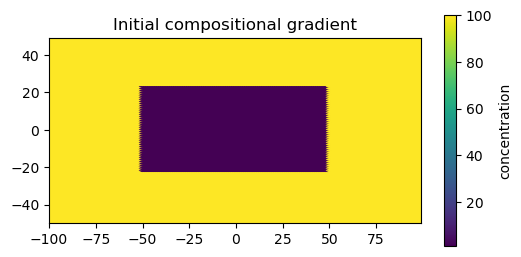

In [2]:
# max distance from the center of the mineral
r = 100  # um
r2 = 50
dx = 1  # m

# array of distance values that will be used to make grid
r_val = np.arange(-r, r, dx)
r_val2 = np.arange(-r2, r2, dx)
# grid of x,y values in cartesian space
x, y = np.meshgrid(r_val, r_val2)

# make some concentric zoning
c1 = 100
c2 = 1
begin = np.ones(50) * c1
middle = np.ones(100) * c2
end = begin
combined = np.hstack((begin, middle, end))

grid = np.zeros((len(r_val2), len(r_val)))
for i in range(len(r_val2)):
    if i < 30:
        grid[i] = c1
    elif i > 75:
        grid[i] = c1
    else:
        grid[i] = combined

u_n = grid.copy()


fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect(1)
p = ax.scatter(x, y, c=grid, marker="o")
cbar = plt.colorbar(p, ax=ax, shrink=0.5)
cbar.set_label("concentration")
ax.set_title(
    "Initial compositional gradient",
)
ax.set_ylim(r_val2.min(), r_val2.max())
ax.set_xlim(r_val.min(), r_val.max())
plt.show()

## Create your 3D zoning


In [3]:
# make a 3D array by stacking your 2D arrays on top of one another
for i in range(50):
    if i == 0:
        stack = np.dstack([grid, grid])
    else:
        stack = np.dstack([stack, grid])

# then tie off the ends so that the zone is concentric in 3D

stack[:, :, 0:10] = c1
stack[:, :, 40:] = c1

## 3D diffusion

### Discretized solution to diffusion in three dimensions

$$\large{{C_{i,j,k}}^{n+1} = {C_{i,j,k}}^{n}+D\Delta t\left[\frac{{C_{i+1,j,k}}^n-2{C_{i,j,k}}^n+{C_{i-1,j,k}}^n}{\Delta x^2} + \frac{{C_{i,j+1,k}}^n-2{C_{i,j,k}}^n+{C_{i,j-1,k}}^n}{\Delta y^2} + \frac{{C_{i,j,k+1}}^n-2{C_{i,j,k}}^n+{C_{i,j,k-1}}^n}{\Delta z^2}\right]}$$
where $n$ is time step, $i$ is x step, and $j$ is y step, and $k$ is a z step. For 3D diffusion the Courant condition is now .125 instead of .5! Make sure:
$$ r = \frac{D\Delta t}{\Delta x^2} < .125$$


In [4]:
sinyear = 60 * 60 * 24 * 365.25
# number of iterations in time
nt = 0.5e3
# 500 year range spaced by half a year. Each iteration is
# .5 years
t = np.arange(0, (nt + 1) * sinyear, sinyear / 2)
dt = t[1] - t[0]
dy = dx
dz = dx
nx = np.shape(stack)[0]
ny = np.shape(stack)[1]
nz = np.shape(stack)[2]
# Sr in orthoclase from Cherniak 1996
D = 6.15e-9
u_n = stack.copy()
u = np.zeros(np.shape(u_n))
# creating a container to put all of your curve iterations
curves = np.zeros((len(t), nx, ny, nz))

# iterating over the length of nt(each iteration is a time step)
for n in tqdm(range(0, len(t))):

    # diffusion equation with constant D. Runs over length of nt for each
    # r value
    u[1: nx - 1, 1: ny - 1, 1: nz - 1] = u_n[
        1: nx - 1, 1: ny - 1, 1: nz - 1
    ] + D * dt * (
        (
            u_n[0: nx - 2, 1: ny - 1, 1: nz - 1]
            - 2 * u_n[1: nx - 1, 1: ny - 1, 1: nz - 1]
            + u_n[2:nx, 1: ny - 1, 1: nz - 1]
        )
        / dx ** 2
        + (
            u_n[1: nx - 1, 0: ny - 2, 1: nz - 1]
            - 2 * u_n[1: nx - 1, 1: ny - 1, 1: nz - 1]
            + u_n[1: nx - 1, 2:ny, 1: nz - 1]
        )
        / dy ** 2
        + (
            u_n[1: nx - 1, 1: ny - 1, 0: nz - 2]
            - 2 * u_n[1: nx - 1, 1: ny - 1, 1: nz - 1]
            + u_n[1: nx - 1, 1: ny - 1, 2:nz]
        )
        / dz ** 2
    )

    # fixing your boundary conditions with above values
    u[0, :, :] = c1
    u[:, 0, :] = c1
    u[:, :, 0] = c1
    u[-1, :, :] = c1
    u[:, -1, :] = c1
    u[:, :, -1] = c1

    # saving your iteration to your curve container
    curves[n, :, :, :] = u
    # switch your variables before the next iteration
    # makes your current u vals the u_n vals in the next loop
    u_n[:, :, :] = u

  0%|          | 0/1002 [00:00<?, ?it/s]

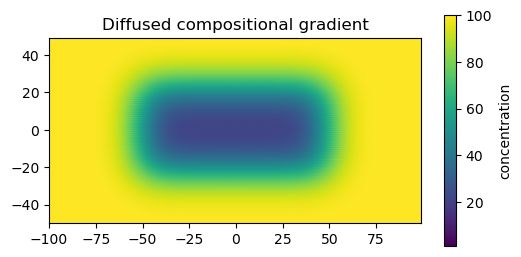

In [5]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_aspect(1)
p = ax.scatter(x, y, c=curves[500, :, :, 30], marker="o", vmin=c2, vmax=c1)
cbar = plt.colorbar(p, ax=ax, shrink=0.5)
cbar.set_label("concentration")
ax.set_title("Diffused compositional gradient")
ax.set_ylim(r_val2.min(), r_val2.max())
ax.set_xlim(r_val.min(), r_val.max())
plt.show()